# RESULTS FINAL

In [3]:
import os 
import numpy as np
import yaml
import json
import pandas as pd

import re
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import msgpack

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import altair as alt
import chartify 

### Defaults

In [54]:
# ALTAIR
alt.renderers.enable('notebook')
alt.themes.enable('vox')

# DEFAULTS - SEABORN
sns.set(
    context='paper',
    style='whitegrid',
    font='serif',
    font_scale=1.33,
    palette='GnBu_d',
    rc={
        'grid.linestyle': ':',
        'grid.color': '.9',
        'axes.edgecolor': '.1',
        'text.color': '.1',
        'axes.spines.right': False,
        'axes.spines.top': False,
        # 'font.serif': ['Times New Roman']
    },
)

# DEFAULTS - PANDAS
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 100)


### Util

In [5]:
def confidence_interval(data, confidence=0.95):
    from scipy.stats import sem, t
    from scipy import mean
    import numpy as np
    # calculate
    if len(data) < 2:
        return np.array(0)
    h = sem(data) * t.ppf((1 + confidence) / 2, len(data) - 1)
    return h  # - np.array([-h, +h]) # + mean(data)

### Data Loaders

In [6]:
def load_raw_wandb_data(LOAD=True, SAVE=True, SAVE_FILE='./data_final.dat.raw', BASE='../results/results-final/wandb'):
    if not LOAD or (SAVE_FILE is None) or not os.path.exists(SAVE_FILE):
        # LOAD GROUP FOLDERS
        folders = [os.path.join(BASE, f) for f in os.listdir(BASE)]
        # LOAD GROUPS
        raw_data = []
        for folder in tqdm(folders):
            # WANDB FILES: wandb.h5, wandb-summary.json, wandb-metadata.json, wandb-history.jsonl, wandb-events.jsonl, requirements.txt, output.log, config.yaml
            try:
                # LOAD CONFIG
                with open(os.path.join(folder, 'config.yaml'), 'rb') as file:
                    config = yaml.load(file)
                    for k, v in config.items():
                        try:
                            config[k] = v['value']
                        except:
                            pass # wandb_version
                # LOAD SUMARY
                with open(os.path.join(folder, 'wandb-summary.json'), 'rb') as file:
                    summary = json.load(file)
                    assert len(summary['run_histories']) == 1
                    summary['run_histories'] = summary['run_histories'][0]
                # APPEND SUMMARY + CONFIG
                raw_data.append((config, summary))
            except Exception as e:
                print(f'SKIPPING: {folder} {e}')
        # SAVE
        if SAVE and (SAVE_FILE is not None):
            with open(SAVE_FILE, 'wb') as file:
                msgpack.pack(raw_data, file)
                print('SAVED RAW DATA')
    else:
        with open(SAVE_FILE, 'rb') as file:
            raw_data = msgpack.unpack(file, raw=False)
            print('LOADED RAW DATA')
    ## GENERAL INFO
    # example_config, example_summary = raw_data[0]
    # pprint(example_config)
    # pprint(list(example_summary.keys()))
    # print('members:', len(example_summary['run_histories']))
    # print('steps:', len(example_summary['run_histories'][0]))
    # pprint(list(example_summary['run_histories'][0][0].keys()))
    ## RETURN
    return raw_data

def load_processed_data(LOAD=True, SAVE=True, SAVE_FILE='./data_final.dat', BASE='../results/results-final/wandb'):
    UNNEEDED_CONFIG_KEYS = {
     '_wandb', 'checkpoint_dir', 'comet_enable', 'path_provider', 'pbt_print', 'pbt_show_progress', 'results_dir', 'wandb_version',
    }

    # Extract Important Data
    if not LOAD or (SAVE_FILE is None) or not os.path.exists(SAVE_FILE):
        data = []
        for config, summary in load_raw_wandb_data(LOAD=LOAD, SAVE=False, SAVE_FILE=None, BASE=BASE):
            scores = np.array([[hist['score'] for hist in m] for m in summary['run_histories']])
            data.append({
                **{k: v for k, v in config.items() if k not in UNNEEDED_CONFIG_KEYS},
                'scores': scores,
                'max_step_scores': scores.max(axis=0),
                'min_step_scores': scores.min(axis=0),
                'mean_step_scores': scores.mean(axis=0),
            })
        data = pd.DataFrame(data)
        if SAVE and (SAVE_FILE is not None):
            data.to_pickle(SAVE_FILE)
            print('SAVED PROCESSED DATA')
    else:
        data = pd.read_pickle(SAVE_FILE)
        print('LOADED PROCESSED DATA')
    # RETURN
    return data

### Load Data

In [7]:
data = load_processed_data(SAVE=True, LOAD=True, SAVE_FILE='./data_final.dat', BASE='../results/results-final/wandb')
sorted(data.columns)

LOADED PROCESSED DATA


['cnn_batch_size',
 'cnn_dataset',
 'cnn_lr_max',
 'cnn_lr_min',
 'cnn_momentum_max',
 'cnn_momentum_min',
 'cnn_steps_per_epoch',
 'cnn_use_cpu',
 'comet_project_name',
 'experiment_id',
 'experiment_name',
 'experiment_repeats',
 'experiment_seed',
 'experiment_type',
 'max_step_scores',
 'mean_step_scores',
 'min_step_scores',
 'pbt_disable_eager_step',
 'pbt_disable_exploit',
 'pbt_disable_explore',
 'pbt_disable_random_order',
 'pbt_exploit_copies_h',
 'pbt_exploit_strategy',
 'pbt_exploit_suggest',
 'pbt_members',
 'pbt_members_ready_after',
 'pbt_target_steps',
 'scores',
 'start_time_str',
 'strategy_ts_ratio_bottom',
 'strategy_ts_ratio_top',
 'suggest_eps',
 'suggest_softmax_temp',
 'suggest_ucb_c',
 'suggest_ucb_incr_mode',
 'tracker_converge_score']

### Graph Helper

In [235]:
def name_row(x):
    s = x['suggest']
    if s == 'ucb':
        return f'{s} c={x["c"]}'
    elif s == 'e-gr':
        return f'{s} ε={x["eps"]}'
    elif s == 'sm':
        return f'{s} τ={x["tau"]}'
    else:
        return f'{s}'

def default_explode(df, type, new_name='score'):
    subset = df.rename(columns={
        'experiment_name': 'name',
        'experiment_id': 'id',
        'pbt_exploit_suggest': 'suggest',
        'suggest_ucb_c': 'c',
        'suggest_softmax_temp': 'tau',
        'suggest_eps': 'eps',
        'pbt_members_ready_after': 'wait',
        f'{type}_step_scores': new_name,
    })
    subset['legend'] = subset.apply(name_row, axis=1)
    subset = subset.explode(new_name)
    subset[new_name] = subset[new_name].astype(float)
    subset['step'] = subset.groupby(['name', 'id']).cumcount() + 1
#     subset = subset.sort_values(['name', 'suggest'], ascending=[True, True])
    subset = subset.sort_values(['legend', 'wait'], ascending=[True, True])
    return subset

def get_axis_lims(type, ready_after, xlim=None, ylim=None):
    assert type in {'mean', 'min', 'max'}
    assert ready_after in {1, 2}
    Y_LIMS = {
        ('max', 1): (90.00, 91.45),
        ('max', 2): (90.00, 91.45),  # (90.15, 91.45)
        ('min', 1): (25, 75),        # (40, 59)
        ('min', 2): (25, 75),
        ('mean', 1): (83.80, 88), # (83.8, 87.4)
        ('mean', 2): (83.80, 88), # (84.95, 87.55)
    }
    if xlim == 'subset':
        xlim = (6, 12)
    elif not xlim:
        xlim = (1, 12)
    if ylim == 'fit':
        ylim = Y_LIMS[(type, ready_after)]
    return xlim, ylim

def set_axis_lims(type, ready_after, xlim=None, ylim=None):
    xlim, ylim = get_axis_lims(type, ready_after, xlim, ylim)
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

def default_filter(df, ready_after=1, names=None, suggest=None):
    assert ready_after in {1, 2, None}
    if ready_after is not None:
        df = df[df['pbt_members_ready_after'] == (ready_after if ready_after is not None else 1)]
    df = df[df['pbt_target_steps'] == 12]
    if suggest:
        df = df[df['pbt_exploit_suggest'].isin(suggest)]
    if names:
        df = df[df['experiment_name'].isin(names)]
    return df


### Plot Seperate

In [170]:
def plot_seperate(data, type='mean', suggest='ucb', main_color='#31C385', ran_color='#EE2B9F', ready_after=1, xlim=(6, 12), ylim='fit', ci=95, save=False, h=4):
    assert suggest in ['ucb', 'e-gr', 'sm']
    
    # FILTER DATA
    df = default_filter(data, ready_after=ready_after, names=None, suggest=[suggest])
    df = default_explode(df, type)
    
    ran = default_filter(data, ready_after=ready_after, names=None, suggest=['ran'])
    ran = default_explode(ran, type)
    
    legend_df = list(df['legend'].unique())
    legend_ran = list(ran['legend'].unique())
        
    g = sns.FacetGrid(df, col='legend', height=h) #, hue='#0000ff')
    g.map(sns.lineplot, 'step', 'score', ci=(ci if ci else None), color=main_color)
    for ax, name in zip(g.axes.flat, legend_df):
        # hue='legend'
        sns.lineplot(x="step", y="score", style='suggest', color=ran_color, ax=ax, data=ran, ci=(ci if ci else None), legend=False)
        ax.set_title(f'{type}: {name}')
#         ax.legend([name] + legend_ran)
    _xlim, _ylim = get_axis_lims(type, ready_after, xlim=xlim, ylim=ylim)
    g.set(xlim=_xlim, ylim=_ylim)
    
    if save:
        os.makedirs('graphs', exist_ok=True)
        plt.savefig(f'graphs/sep/sep_{type}_r{ready_after}_{suggest}_{ci}_{xlim}', dpi=400)
    plt.show()


In [171]:
def plot_all_seperate(type, subset=True, save=True):
    xlim, ylim = ('subset', 'fit') if subset else (None, None)
    plot_seperate(data, type, ready_after=1, suggest='ucb',  xlim=xlim, ylim=ylim, main_color='#31C385', h=2.25, save=save)
    plot_seperate(data, type, ready_after=2, suggest='ucb',  xlim=xlim, ylim=ylim, main_color='#31C385', h=2.25, save=save)
    plot_seperate(data, type, ready_after=1, suggest='e-gr', xlim=xlim, ylim=ylim, main_color='#F79337', h=2.25, save=save)
    plot_seperate(data, type, ready_after=2, suggest='e-gr', xlim=xlim, ylim=ylim, main_color='#F79337', h=2.25, save=save)
    plot_seperate(data, type, ready_after=1, suggest='sm',   xlim=xlim, ylim=ylim, main_color='#38AFEE', h=2.25, save=save)
    plot_seperate(data, type, ready_after=2, suggest='sm',   xlim=xlim, ylim=ylim, main_color='#38AFEE', h=2.25, save=save)

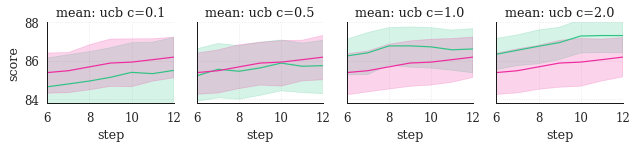

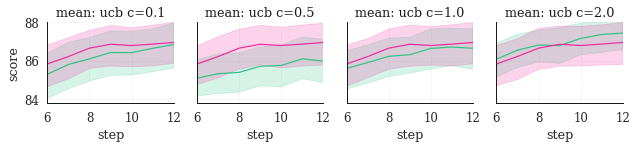

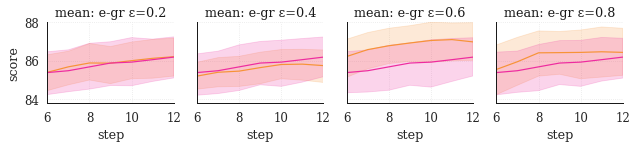

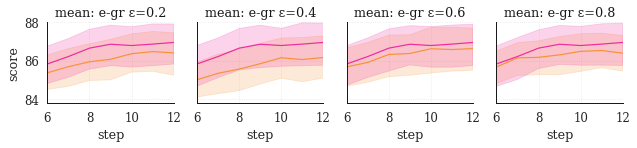

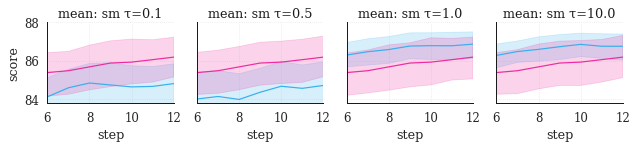

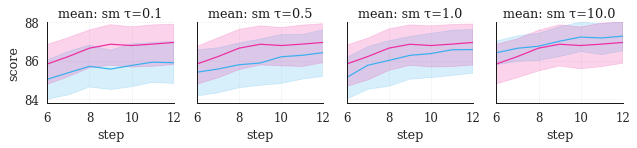

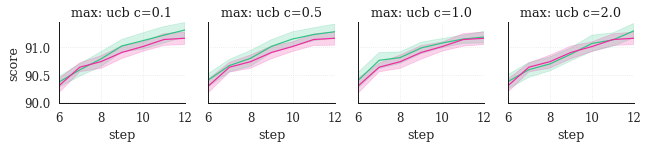

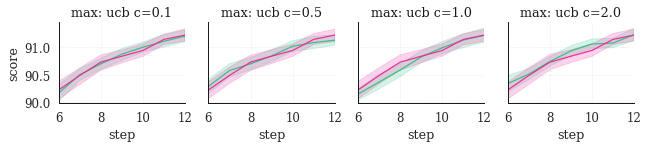

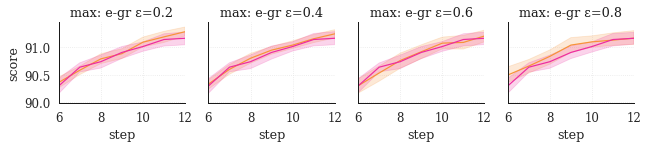

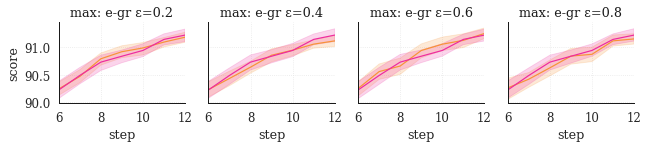

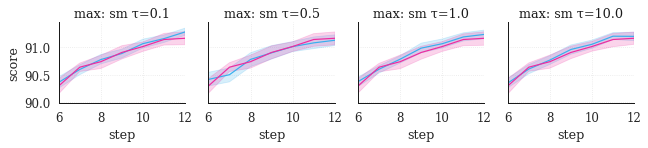

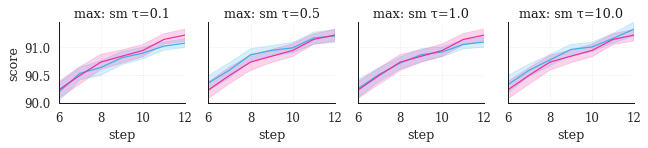

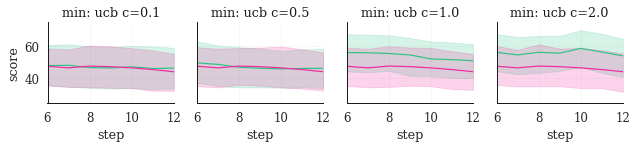

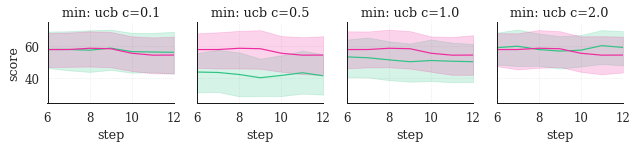

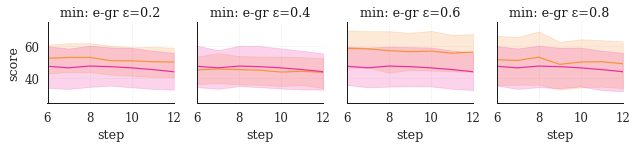

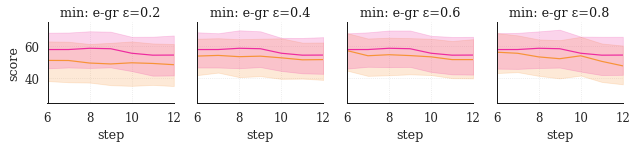

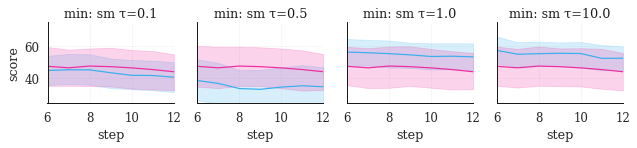

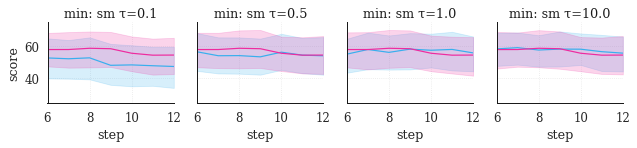

In [172]:
plot_all_seperate('mean')
plot_all_seperate('max')
plot_all_seperate('min')

### Plot Full

In [177]:
def plot_lines(data, type='mean', suggest='ucb', main_color='#31C385', ran_color='#EE2B9F', ready_after=1, xlim=(6, 12), ylim='fit', ci=None, save=False, figsize=(7,3)):
    assert suggest in ['ucb', 'e-gr', 'sm']
    
    # FILTER DATA
    df = default_filter(data, ready_after=ready_after, names=None, suggest=[suggest])
    df = default_explode(df, type)
    
    ran = default_filter(data, ready_after=ready_after, names=None, suggest=['ran'])
    ran = default_explode(ran, type)
    
    legend_df = list(df['legend'].unique())
    legend_ran = list(ran['legend'].unique())
    
    palette = sns.light_palette(main_color, len(legend_df)+1)[1:]
    
    plt.figure(figsize=figsize)
    set_axis_lims(type, ready_after, xlim=xlim, ylim=ylim)
    sns.lineplot(x="step", y="score", hue='legend', style='suggest', data=df, ci=(95 if ci else None), palette=palette)
    sns.lineplot(x="step", y="score", color=ran_color, style='suggest', data=ran, ci=(95 if ci else None))
    plt.legend(labels=legend_df, loc='lower right')
    
    if save:
        os.makedirs('graphs', exist_ok=True)
        plt.savefig(f'graphs/all/all_{type}_r{ready_after}_{suggest}_{ci}_{xlim}', dpi=400)
    plt.show()


In [181]:
def plot_all_lines(type, subset=False, save=True):
    xlim, ylim = ('subset', 'fit') if subset else (None, None)
    plot_lines(data, type, ready_after=1, suggest='ucb',  xlim=xlim, ylim=ylim, main_color='#31C385', save=save)
    plot_lines(data, type, ready_after=2, suggest='ucb',  xlim=xlim, ylim=ylim, main_color='#31C385', save=save)
    plot_lines(data, type, ready_after=1, suggest='e-gr', xlim=xlim, ylim=ylim, main_color='#F79337', save=save)
    plot_lines(data, type, ready_after=2, suggest='e-gr', xlim=xlim, ylim=ylim, main_color='#F79337', save=save)
    plot_lines(data, type, ready_after=1, suggest='sm',   xlim=xlim, ylim=ylim, main_color='#38AFEE', save=save)
    plot_lines(data, type, ready_after=2, suggest='sm',   xlim=xlim, ylim=ylim, main_color='#38AFEE', save=save)

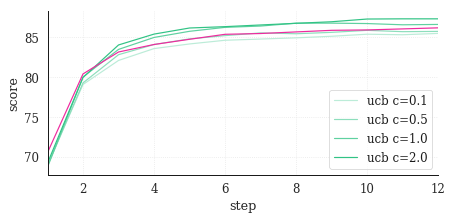

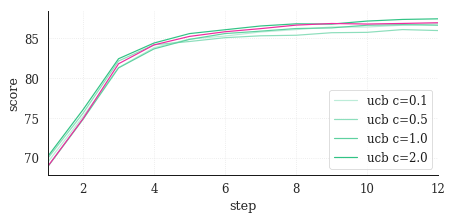

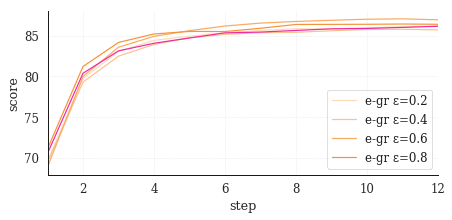

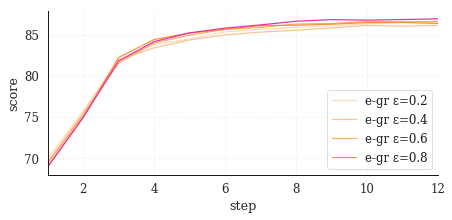

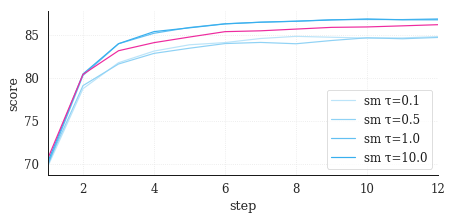

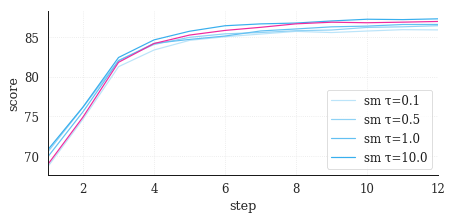

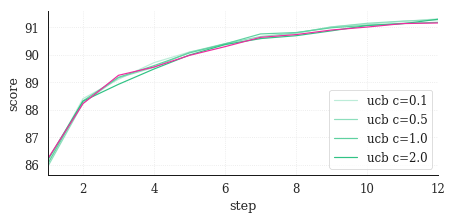

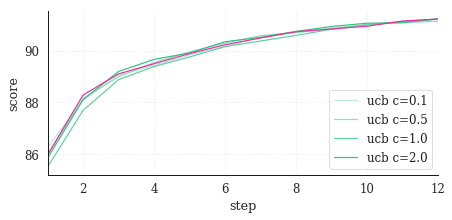

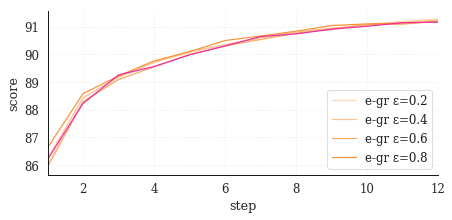

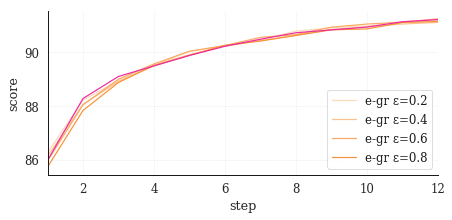

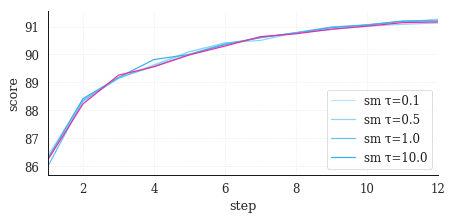

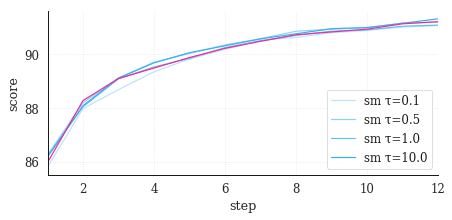

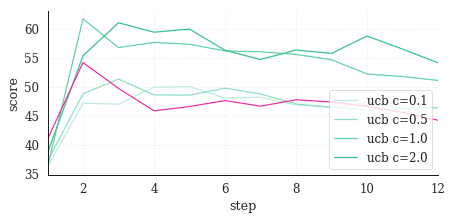

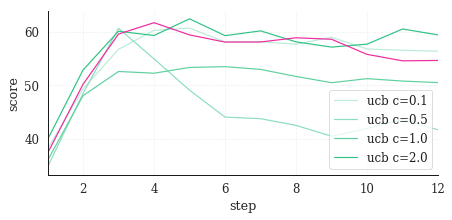

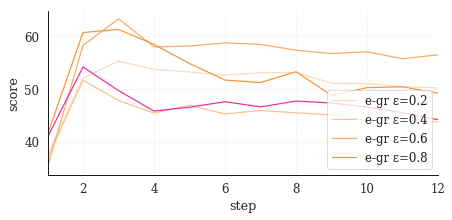

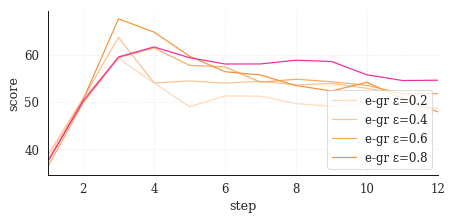

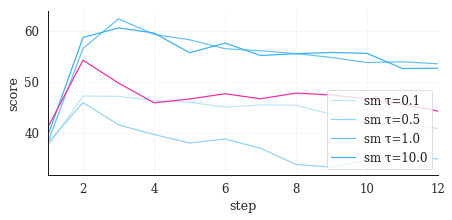

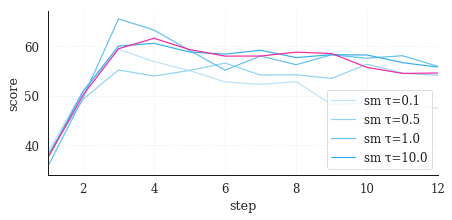

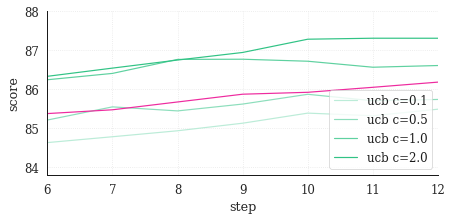

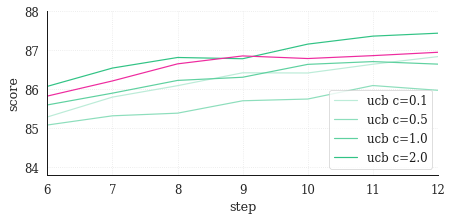

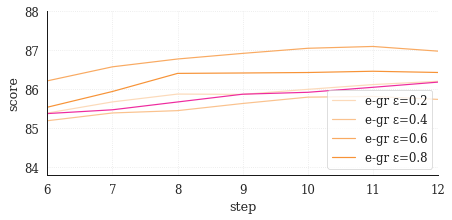

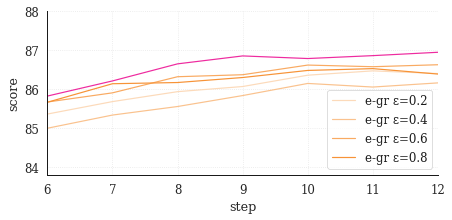

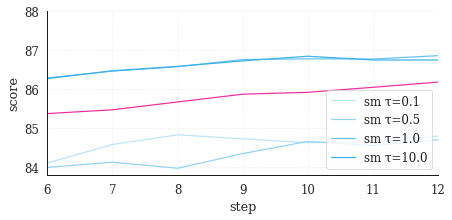

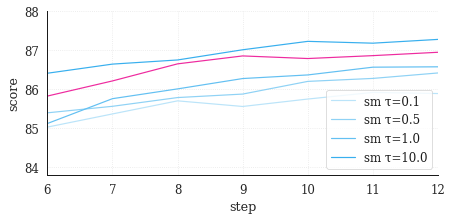

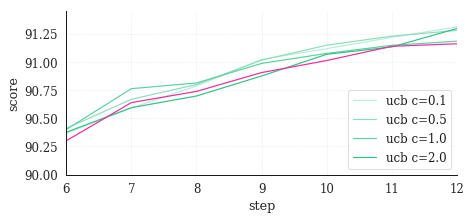

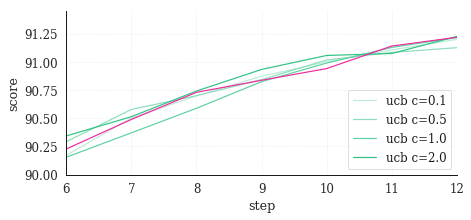

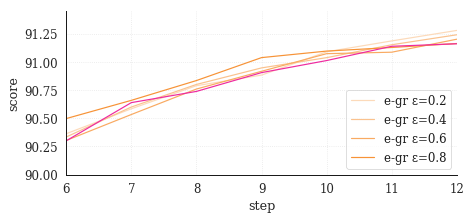

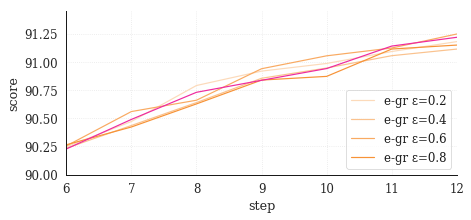

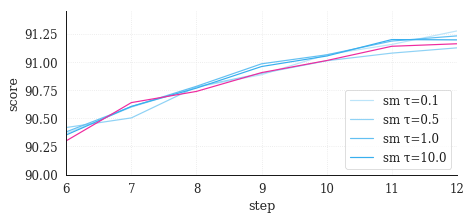

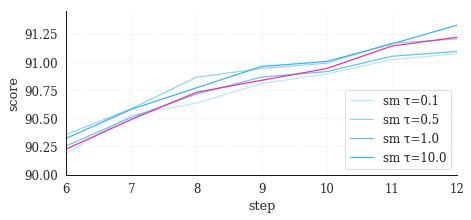

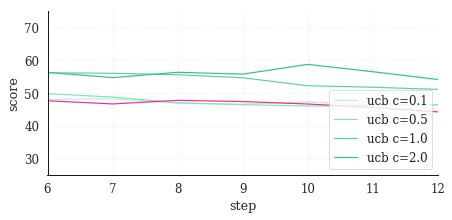

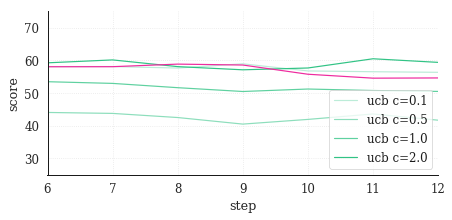

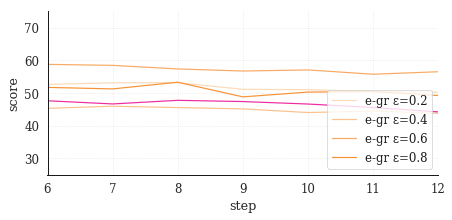

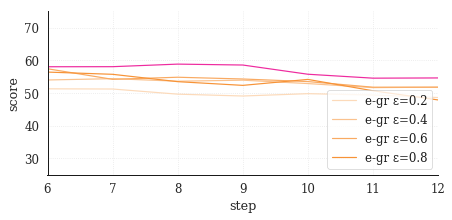

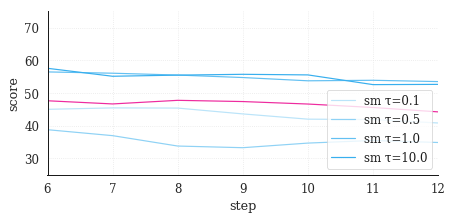

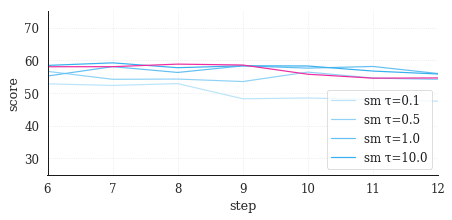

In [183]:
plot_all_lines('mean', subset=False)
plot_all_lines('max', subset=False)
plot_all_lines('min', subset=False)

plot_all_lines('mean', subset=True)
plot_all_lines('max', subset=True)
plot_all_lines('min', subset=True)

### Side By Side

In [236]:
def plot_pairs(data, type='mean', suggest='ucb', main_color='#31C385', ran_color='#EE2B9F', xlim=(6, 12), ylim='fit', ci=None, save=False, h=3):
    assert suggest in ['ucb', 'e-gr', 'sm']
    
    # FILTER DATA
    df = default_filter(data, ready_after=None, names=None, suggest=[suggest])
    df = default_explode(df, type)
    
    legend_df = list(df['legend'].unique())
    unique_wait = list(df['wait'].unique())
    
    rans = [
        (wait, default_explode(default_filter(data, ready_after=None, names=None, suggest=['ran']), type))
        for wait in unique_wait
    ]
    palette = sns.light_palette(main_color, len(legend_df)+1)[1:]
    
    g = sns.FacetGrid(df, col='wait', hue='legend', height=h, palette=palette) #, hue='#0000ff')
    g.map(sns.lineplot, 'step', 'score', ci=(ci if ci else None))
    for ax, (wait, ran) in zip(g.axes.flat, rans):
        sns.lineplot(x="step", y="score", style='suggest', color=ran_color, ax=ax, data=ran, ci=(ci if ci else None), legend=False)
        ax.set_title(f'wait: {wait}')
    _xlim, _ylim = get_axis_lims(type, 1, xlim=xlim, ylim=ylim)
    g.set(xlim=_xlim, ylim=_ylim)
    g.add_legend()
    
    if save:
        os.makedirs('graphs', exist_ok=True)
        plt.savefig(f'graphs/pair/pair_{type}_{suggest}_{ci}_{xlim}', dpi=400)
    plt.show()

In [237]:
def plot_all_pairs(type, subset=True, save=True):
    xlim, ylim = ('subset', 'fit') if subset else (None, None)
    plot_pairs(data, type, suggest='ucb',  xlim=xlim, ylim=ylim, main_color='#31C385', save=save)
    plot_pairs(data, type, suggest='e-gr', xlim=xlim, ylim=ylim, main_color='#F79337', save=save)
    plot_pairs(data, type, suggest='sm',   xlim=xlim, ylim=ylim, main_color='#38AFEE', save=save)

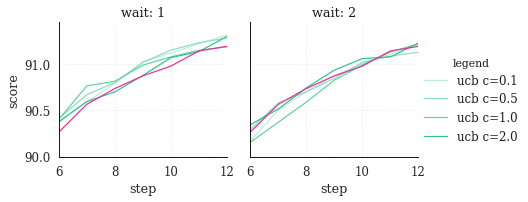

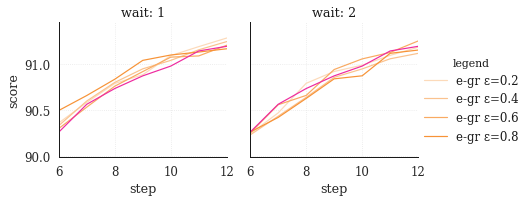

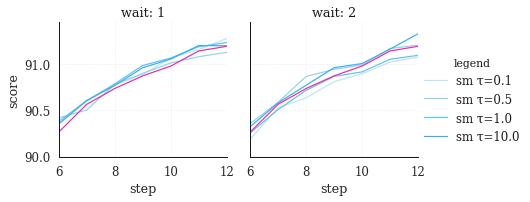

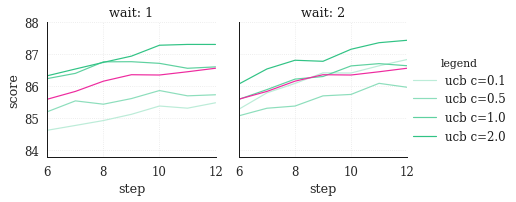

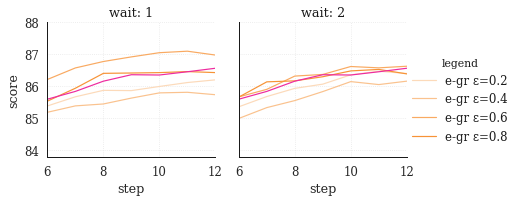

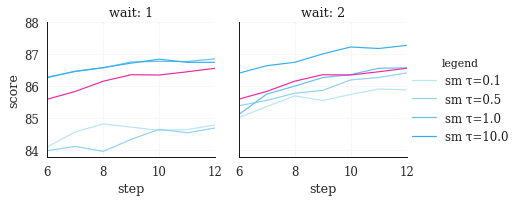

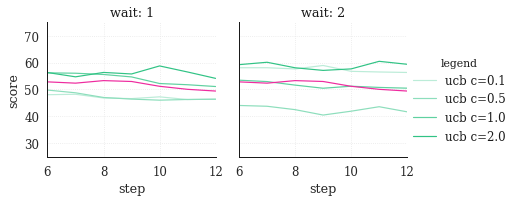

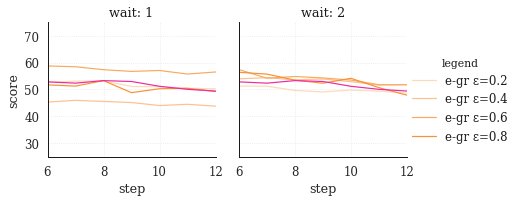

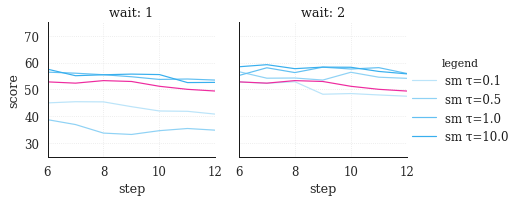

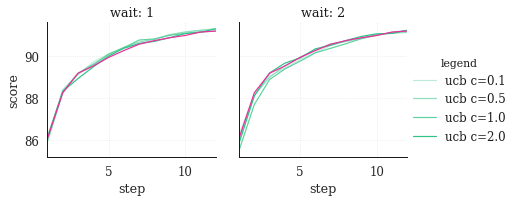

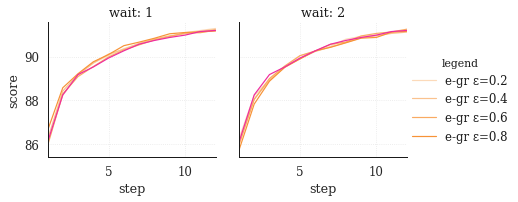

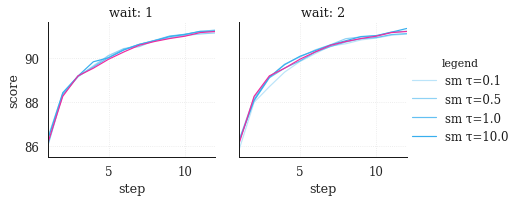

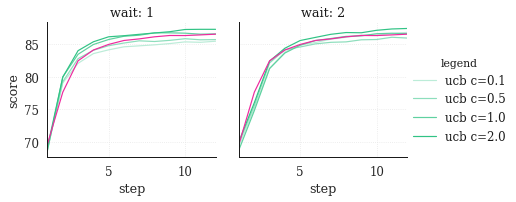

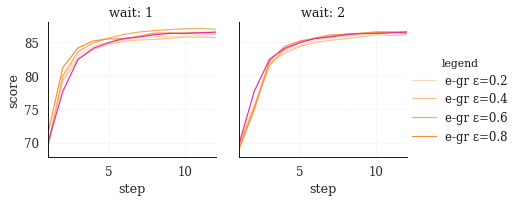

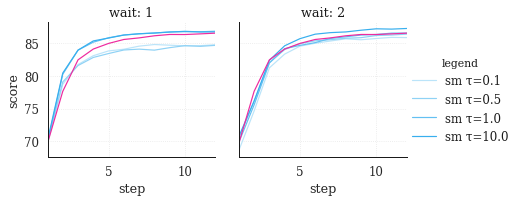

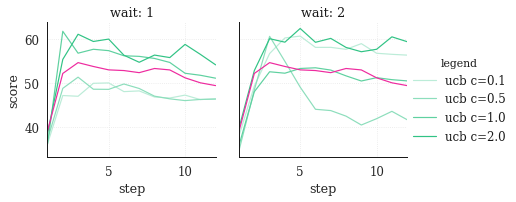

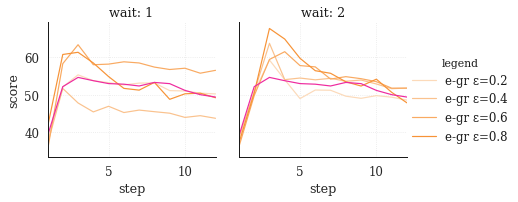

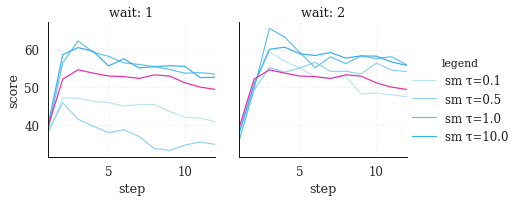

In [238]:
plot_all_pairs('max', subset=True)
plot_all_pairs('mean', subset=True)
plot_all_pairs('min', subset=True)

plot_all_pairs('max', subset=False)
plot_all_pairs('mean', subset=False)
plot_all_pairs('min', subset=False)

### Triple Together

In [305]:
def plot_triple(data, type='mean', ready_after=1, ran_color='#EE2B9F', xlim=(6, 12), ylim='fit', ci=None, save=False, h=5):
    assert ready_after in {1, 2}
    
    # FILTER DATA
    suggests = ['ucb', 'e-gr', 'sm']
    colors = ['#31C385', '#F79337', '#38AFEE']
    df = default_filter(data, ready_after=ready_after, names=None, suggest=suggests)
    df = default_explode(df, type)
    df = df.sort_values(['suggest'], ascending=[True])
    
    palette = [(s, c, default_explode(default_filter(data, ready_after=None, names=None, suggest=[s]), type)) for s, c in [('ucb', '#31C385'), ('e-gr', '#F79337'), ('sm', '#38AFEE')]]
    palette = [(s, c, df, list(df['legend'].unique())) for s, c, df in palette]
    palette = [color for s, c, df, u in palette for color in sns.light_palette(c, len(u)+1)[1:]]
    
    ran = default_filter(data, ready_after=ready_after, names=None, suggest=['ran'])
    ran = default_explode(ran, type)
    
    g = sns.FacetGrid(df, col='suggest', hue='legend', height=h, palette=palette) #, hue='#0000ff')
    g.map(sns.lineplot, 'step', 'score', ci=(ci if ci else None))
    for ax, suggest in zip(g.axes.flat, suggests):
        sns.lineplot(x="step", y="score", style='suggest', color=ran_color, ax=ax, data=ran, ci=(ci if ci else None), legend=False)
        ax.set_title(f'suggest: {suggest}')
    _xlim, _ylim = get_axis_lims(type, ready_after, xlim=xlim, ylim=ylim)
    g.set(xlim=_xlim, ylim=_ylim)
    g.add_legend()
    
    if save:
        os.makedirs('graphs', exist_ok=True)
        plt.savefig(f'graphs/triple/triple_{type}_{suggest}_{ci}_{xlim}', dpi=400)
    plt.show()

In [306]:
def plot_all_triples(type, subset=True, save=True):
    xlim, ylim = ('subset', 'fit') if subset else (None, None)
    plot_triple(data, type, ready_after=1,  xlim=xlim, ylim=ylim, save=save)
    plot_triple(data, type, ready_after=2, xlim=xlim, ylim=ylim, save=save)

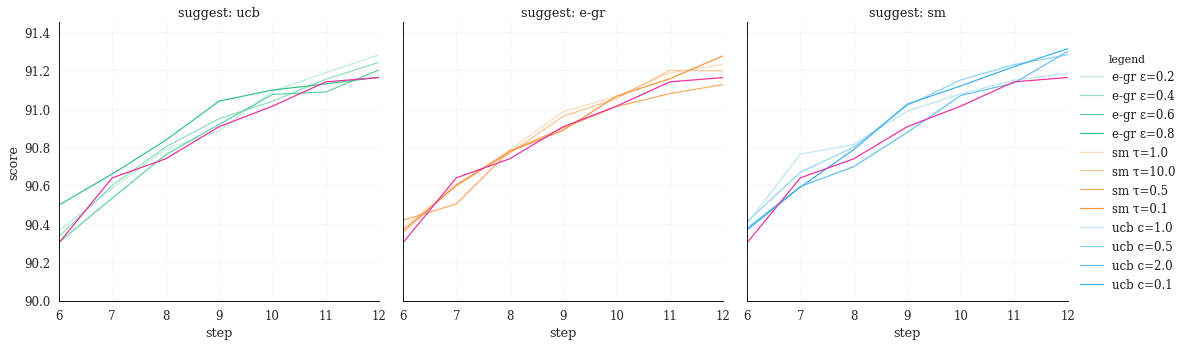

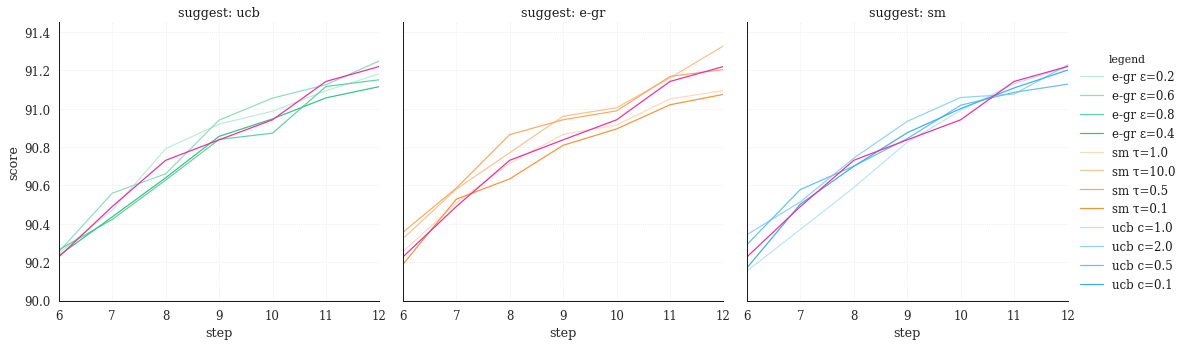

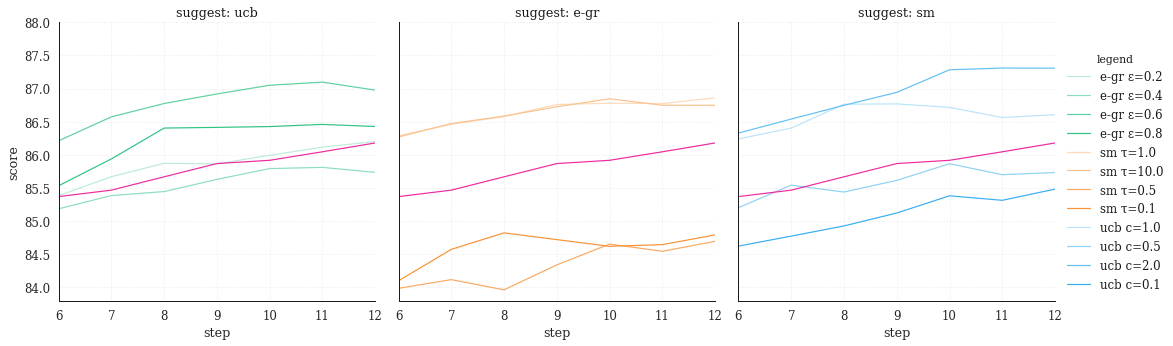

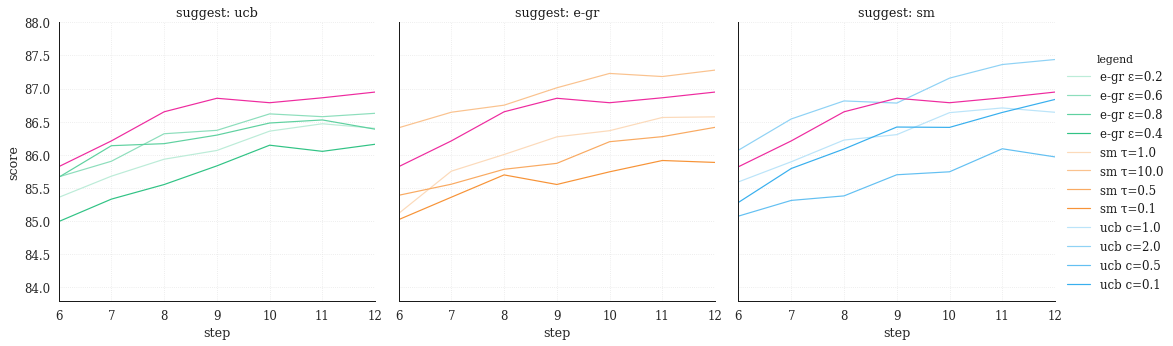

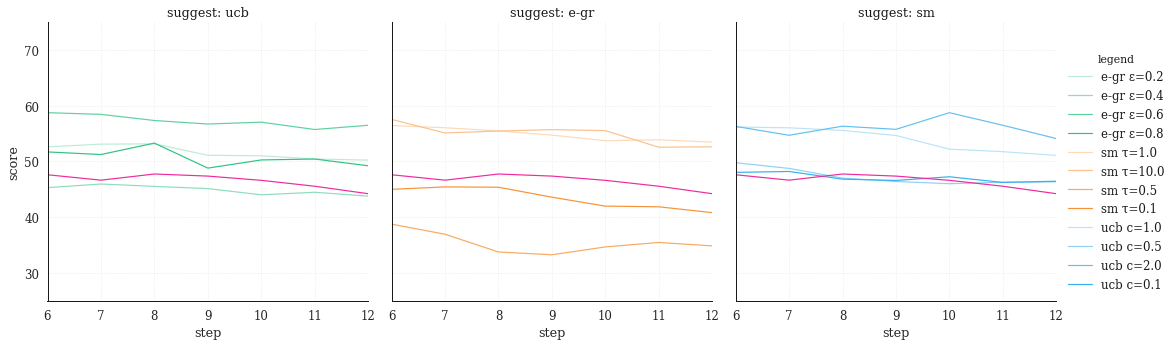

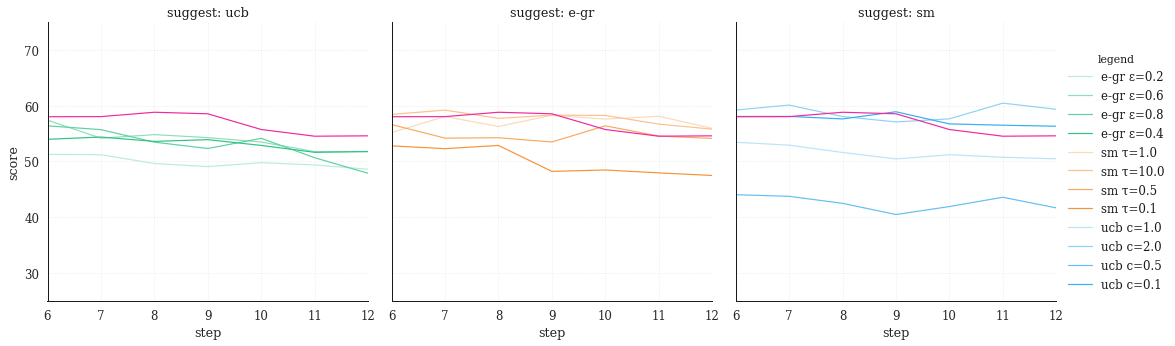

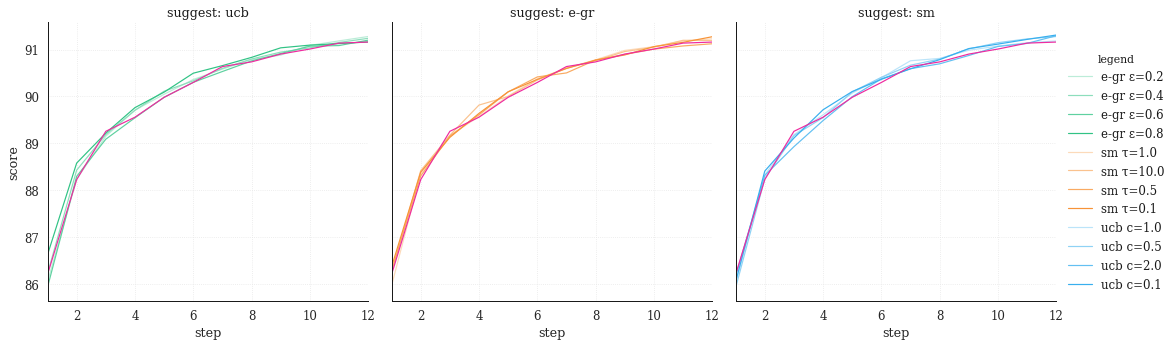

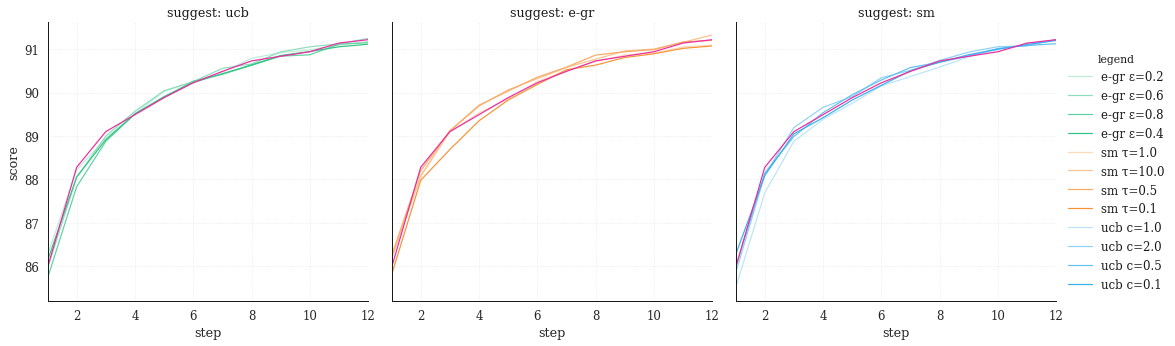

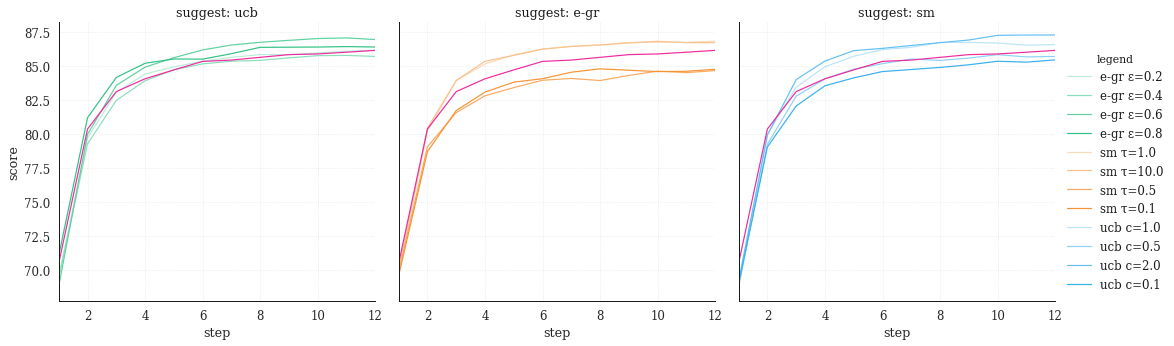

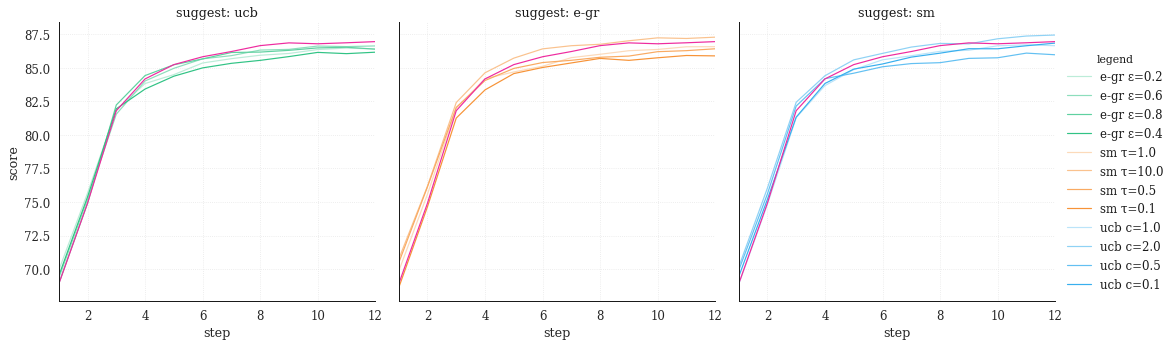

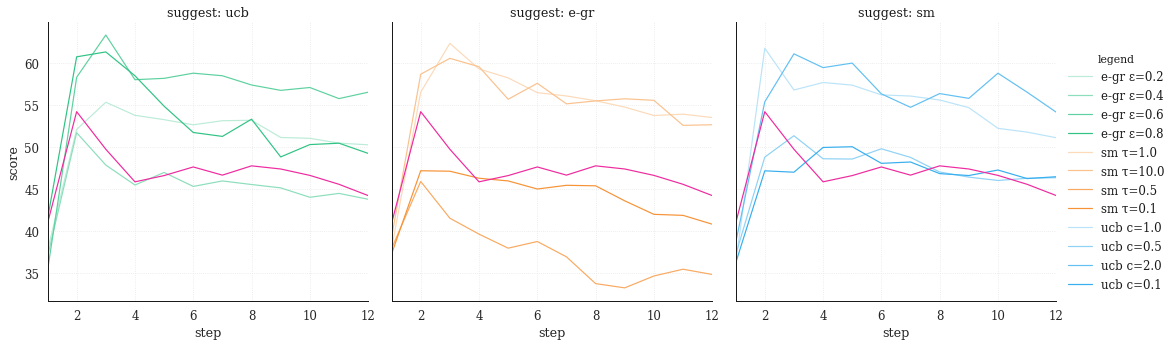

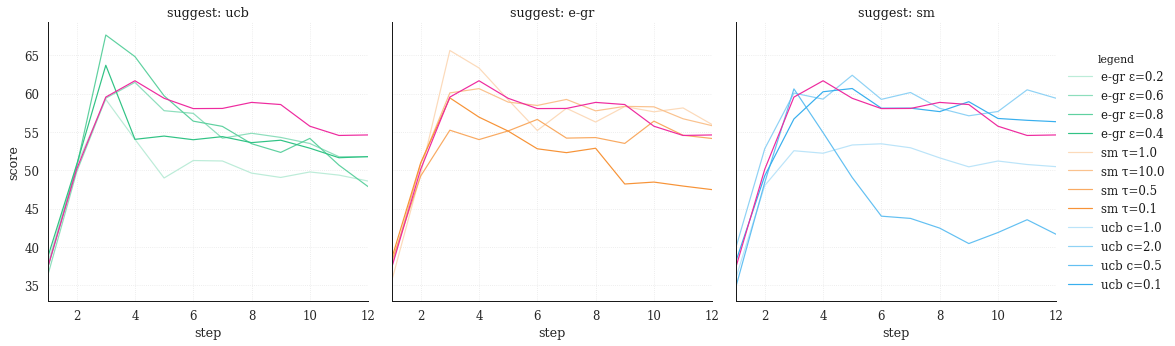

In [307]:
plot_all_triples('max', subset=True)
plot_all_triples('mean', subset=True)
plot_all_triples('min', subset=True)

plot_all_triples('max', subset=False)
plot_all_triples('mean', subset=False)
plot_all_triples('min', subset=False)